In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from scipy.stats import zscore
import seaborn as sns
from sklearn.cross_decomposition import PLSRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from itertools import cycle
from vips import vipp
from calc_metrics import calc_metrics
import random

In [3]:
### all have been normed

In [2]:
counts = pd.read_csv('../data/BAL/Reseq_ALL/counts_reseq.csv', sep='\t', 
                     index_col='sample_id')
meta = pd.read_csv('../data/BAL/Reseq_ALL/meta_reseq.csv', sep='\t', index_col='sample_id')

## GET VIPS for DE

#### getEven takes the positive samples, and gets an equal number of neg samples
#### This makes the prediction accuracy for pos vs. neg more interpretable

In [10]:

def filter_norm(df, meta, celltype, rem_loners=False, min_gene_count=min_gene_count, min_uniques=min_uniques):
    dfm = meta[meta['CellType']==celltype]
    #if rem_loners and celltype=='CD163':
    #    loners163 =['BAL'+str(x) for x in [89,83,66,17,76,86,21,35,79,85,84,38,28,55,75,87, 57, 74]] 
    #    dfm = dfm[~dfm['BAL'].isin(loners163)]
    #    df = df.ix[dfm.index]
    #print df.shape, "after removing loners"
    df = df.ix[dfm.index]
    dfm['Norm_Factor'] = dfm['Uniquely mapped reads number'].map(lambda x: float(x) / np.median(dfm['Uniquely mapped reads number']))
    
    samples_min_unique = dfm[dfm['Uniquely mapped reads number'] > min_uniques].index
    df = df.ix[samples_min_unique].T
    for i in df.columns:
        norm_fac = dfm.loc[i,'Norm_Factor']
        df[i] = df[i].map(lambda x: float(x)/norm_fac)
    df = df.T
    df = df.loc[:, df.min(axis=0) > min_gene_count]
    df = df.apply(lambda x: np.log2(x + 1))
    dfm = dfm.ix[df.index]
    return df, dfm

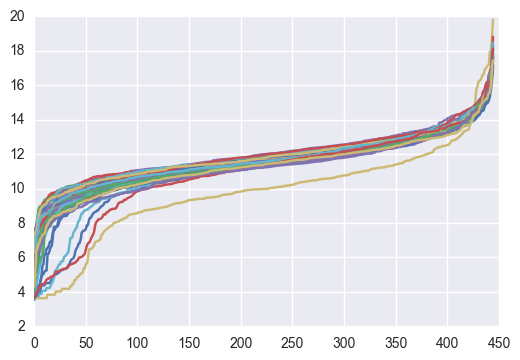

In [100]:
for i in range(df.shape[0]):
    plt.plot(sorted(df.ix[i]))

In [11]:
min_uniques = 1e6
min_gene_count = 1 ## All genes from all samples must have 10 counts
## AM
def geteven_xy(df, meta, celltype):
    df, dfm = filter_norm(df, meta, celltype, min_gene_count=min_gene_count, rem_loners=True,
                   min_uniques=min_uniques)
    X = np.array(df)
    y = dfm.ix[df.index]['Pneum'].values
    pos = [i for i in range(len(y)) if y[i]==True]
    neg = random.sample([i for i in range(len(y)) if y[i]==False],len(pos))
    y = y[pos + neg] 
    X = X[pos + neg] 
    return X,y

## PLSR - Q score

### Plot # of Top VIP genes vs Q2, classification accuracy, class. error

## Still need to compare to jumbled genes

In [12]:
def vip_vs_Q2(df, meta, celltype,  n_pcs=5, max_vips=200, n_top=20, increment=5, start=10):
    

    X, y = geteven_xy(df, meta, celltype) ### Gets an even # of pos, neg from data
    print X.shape
    Q2s = []
    Nvip = []
    neg_errs = []
    pos_errs = []
    neg_correct = []
    pos_correct = []
    top_genes_cum = []
    
    for n in range(start, max_vips, increment):
        
        Nvip.append(n)
        
        neg_err, pos_err, Q2, pos_corr, neg_corr, vip_inds = calc_metrics(X, y, n_pcs, n_top_genes=n)
        
        neg_errs.append(np.mean(neg_err))
        pos_errs.append(np.mean(pos_err))
        neg_correct.append(neg_corr)
        pos_correct.append(pos_corr)
        Q2s.append(np.mean(Q2))
        
        ### Get the top n_top genes for all models built with n VIP genes
        top_genes = pd.Series([v for grp in vip_inds for v in grp]).value_counts().index[:n_top]
        top_genes_cum.append(top_genes)
        #print top_genes
        #break
    d = {'Negative errors':neg_errs, 'Positive errors': pos_errs, 
         'Negative correct':neg_correct, 'Positive correct': pos_correct,
         'N': Nvip, 'Q squared': Q2s}
    
    all_top_genes = pd.Series([v for grp in top_genes_cum for v in grp]).value_counts()
    
    n_highest_Q = np.argsort(Q2s)
    #print n_highest_Q, Q2s
    
    #print "Max possible count for a gene in top_genes: ", int(max_vips - 10)/increment
    return d, all_top_genes

In [13]:
dAM, top_genes = vip_vs_Q2(counts, meta, celltype='AM', max_vips=200, n_top=20, increment=2)

(34, 523)


In [15]:
dAM['Negative errors']

[0.43961222933858357,
 0.42120504643191314,
 0.41269692404358244,
 0.43097439595219716,
 0.46843827604621796,
 0.46205560061295364,
 0.49872463597064287,
 0.50889537824220865,
 0.51653535618305557,
 0.49052032300843479,
 0.4775600897260367,
 0.49851180187534588,
 0.48833742365316785,
 0.50019409540906301,
 0.49039612030249152,
 0.48648360324052053,
 0.50023808219058086,
 0.51213412507962375,
 0.49527790365476299,
 0.4954198563692484,
 0.50237042837571977,
 0.48984530920843333,
 0.47469682148022985,
 0.48238540175874695,
 0.4891507459232578,
 0.48712212651756026,
 0.48922249398909079,
 0.49964988668653065,
 0.49408490596856347,
 0.4951725949554846,
 0.49998865177272633,
 0.50354533973074578,
 0.50131418292882557,
 0.49523420421179493,
 0.50093076493189403,
 0.50404804518567592,
 0.49795812480778567,
 0.49728397819356757,
 0.49884219841878924,
 0.50022333673635999,
 0.48860235084103421,
 0.48648065243033317,
 0.48117591134688392,
 0.47661804273313491,
 0.46750074104038286,
 0.46837295324

In [20]:
d163, top_genes = vip_vs_Q2(counts, meta, celltype='CD163', max_vips=200, n_top=20, increment=2)

(28, 1186)


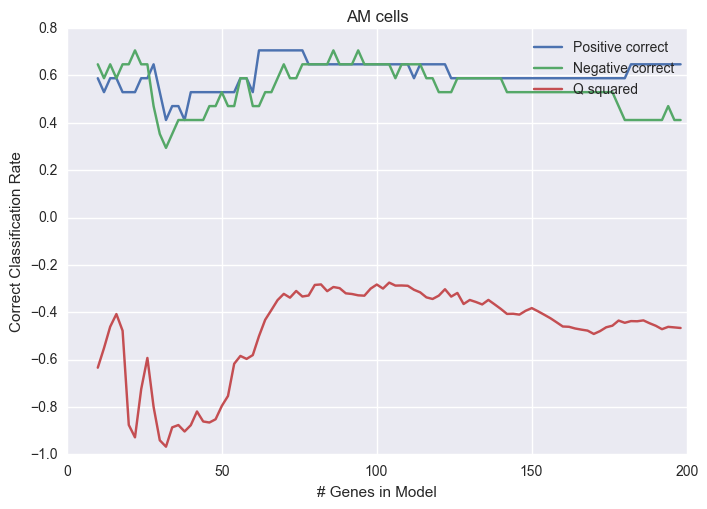

In [18]:
plot_vip(dAM, to_plot)
plt.xlabel("# Genes in Model")
plt.ylabel("Correct Classification Rate")
plt.title("AM cells")

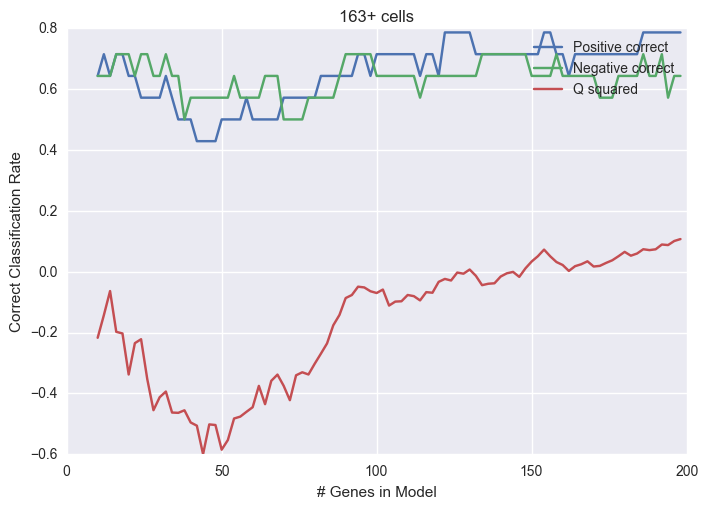

In [21]:
plot_vip(d163, to_plot)
plt.xlabel("# Genes in Model")
plt.ylabel("Correct Classification Rate")
plt.title("163+ cells")

In [1]:
def plot_vip(d, to_plot, xmax=500):
    for i, k in enumerate(to_plot):
        plt.plot(d['N'][:xmax], d[k][:xmax], label=to_plot[i])
    plt.legend()

to_plot = ['Positive correct', 'Negative correct', 'Q squared']
fig = plt.figure(figsize=(8,6))
plot_vip(dAM, to_plot)

plt.xlabel(" # Top VIP Genes" , fontsize=14)
plt.ylabel(" Fraction classified correctly" , fontsize=14)
plt.legend()

NameError: name 'plt' is not defined

In [8]:
def plot_vip(d, to_plot, xmax=500):
    fig = plt.figure(figsize=(8,6))
    for k in to_plot:
        plt.plot(d['N'][:xmax], d[k][:xmax], label=k)
    plt.xlabel(" # Top VIP Genes" , fontsize=14)
    plt.ylabel(" Fraction classified correctly" , fontsize=14)
    plt.legend()

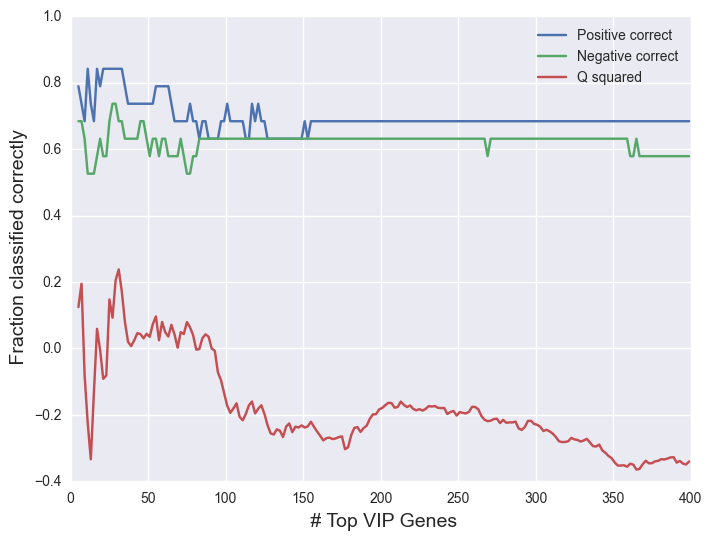

In [113]:
to_plot = ['Positive correct', 'Negative correct', 'Q squared']
plot_vip(dAM, to_plot)

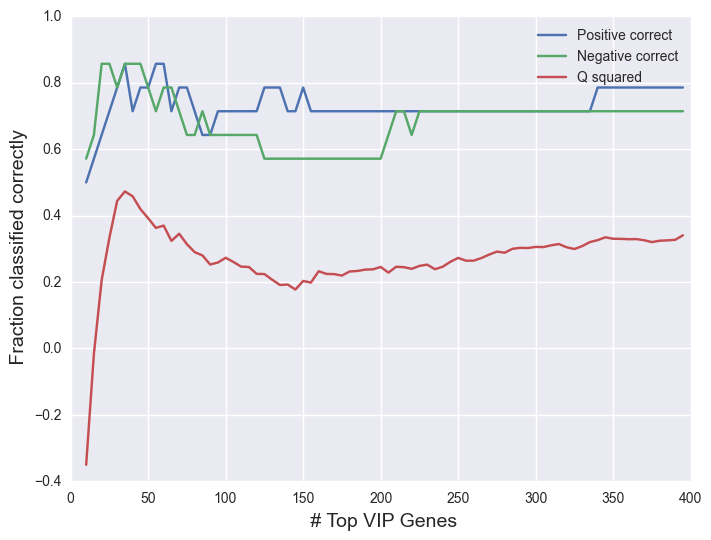

In [111]:
to_plot = ['Positive correct', 'Negative correct', 'Q squared']

plot_vip(d163, to_plot)

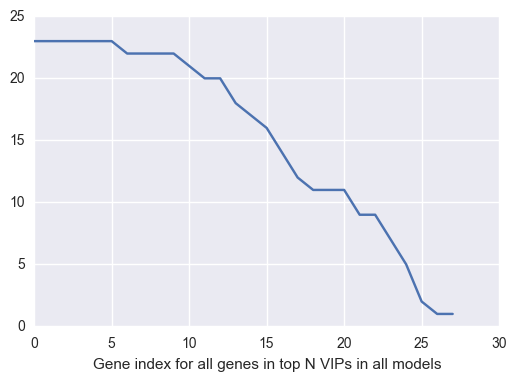

In [109]:
plt.plot(top_genes)
plt.xlabel("Gene index for all genes in top N VIPs in all models")

In [101]:
d163, top_genes = vip_vs_Q2(df163, nmax=400, n_top=20)

Max:  78


In [6]:
def calc_metrics(X, y, n_pcs, n_top_genes):
    
    n_samples = len(X)
    pred = []
    vip_inds_all = []
    #print X.shape, y.shape
    for sample in range(n_samples):
        samples = range(n_samples)
        samples.remove(sample)
        X_t = X[(samples)]
        y_t = y[(samples)]
        #print X_t.shape    
        
        ### Get VIPs for model built without the LOO sample
        plsv = PLSRegression(5, scale=False)
        plsv.fit(X_t, y_t)
        vips = vipp(X_t, y_t, plsv.x_scores_, plsv.x_weights_)
        vips = [float(v) for v in vips]
        vip_inds = np.argsort(vips)[::-1][:n_top_genes]
        vip_inds_all.append(vip_inds)
        
        ### Xn takes the original X to get the loo sample
        Xn = X.T[vip_inds].T
        loo_sample = Xn[sample]
        loo_sample = np.array(loo_sample).reshape((1, -1))
        
        ### Filter the samples 
        X_tn = X_t.T[vip_inds].T
        #print X_tn.shape
        pls = PLSRegression(n_pcs, scale=False)
        pls.fit(X_tn, y_t)

        pred.append(float(pls.predict(loo_sample)))

    # Calculate metrics
    ### Q squared
    num = sum([float((pred[i] - y[i]))**2 for i in range(len(pred))])
    den = sum([(y[i] - np.mean(y))**2 for i in range(len(pred))])
    Q2 = float(1 - num/den)

    ### Prediction error
    errs = [abs(float((pred[i] - y[i]))) for i in range(len(pred))]
 
    ### Percent correct for neg and pos Pneumonia
    neg_err = [errs[i] for i in range(len(errs)) if y[i]==0]  
    neg_corr = [e < 0.5 for e in neg_err]   
    neg_corr = float(sum(neg_corr)) / len(neg_err)

    
    pos_err = [errs[i] for i in range(len(errs)) if y[i]==1]
    pos_corr = [e < 0.5 for e in pos_err]
    pos_corr = float(sum(pos_corr)) / len(pos_err)
    

    #print "num: {0: .3f}, den: {1: .3f}, 
    #print "Q^2: {0: .3f}".format(Q2)
    
    return neg_err, pos_err, Q2, neg_corr, pos_corr, vip_inds_all
    #return [float(abs(pred[p] - y[p])) for p in range(len(pred))]

In [7]:
def vipp(x, y, t, w):

    """
    From original MATLAB code
    See https://code.google.com/p/carspls/

    #+++ vip=vipp(x,y,t,w);
    #+++ t: scores, which can be obtained by pls_nipals.m
    #+++ w: weight, which can be obtained by pls_nipals.m
    #+++ to calculate the vip for each variable to the response;
    #+++ vip=sqrt(p*q/s);
    """
    #initializing
    [p, h] = w.shape
    co = np.matrix(np.zeros([1, h]))

    # Calculate s
    for ii in range(h):
        corr = np.corrcoef(y, t[:, ii], rowvar=0)
        co[0, ii] = corr[0, 1]**2
    s = np.sum(co)

    # Calculate q
    # This has been linearized to replace the original nested for loop
    w_power = np.power(w, 2)
    d = np.multiply(w_power, co)
    q = np.sum(d, 1)
    vip = np.sqrt(p*q/s)
    return vip

In [14]:
def calc_Q2_kfold(X, y, k=5, n_rand=10, n_pcs=5, method='PLSR'):
    n_samples = len(X)
    pred = []
    Q2s = []
    for ki in range(n_rand):
        sample_ind = range(n_samples)
        withheld_samples = random.sample(sample_ind, k)
        lo_samples = X[withheld_samples]
        for s in withheld_samples:
            sample_ind.remove(s)
        X_t = X[(sample_ind)]
        y_t = y[(sample_ind)]
        if method=='PLSR':
            model = PLSRegression(n_pcs, scale=False)
        elif method=='RF':
            model = RandomForestClassifier()
        elif method=='SVM':
            model = SVC()
        else:
            print "Method not found"
        model.fit(X_t, y_t)

        for s in withheld_samples:
            pred.append(float(model.predict(X[s])))
        #Eprint "samples", withheld_samples
        #Eprint "pred", pred
        num = sum([(pred[i] - y[s])**2 for i, s in enumerate(withheld_samples)])
        den = sum([(y[s] - np.mean(y[withheld_samples]))**2 for s in withheld_samples])
        Q2 = float(1- num/den)
        Q2s.append(Q2)
    print "Q^2: mean={0: .2f}, std={1: .2f}".format(np.mean(Q2s),np.std(Q2s))
    #return [float(abs(pred[p] - y[p])) for p in range(len(pred))]